In this notebook, we will use Gated Recurrent Units to develop time series forecasting models.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temparature, dewpoint and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
# import module
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
# Read the dataset into a pandas.DataFrame
df = pd.read_csv(
    '../Data Files/PRSA_data_2010.1.1-2014.12.31.csv'
)
print('Shape of the dataframe:', df.shape)
# Let's see the first five rows of the DataFrame
df.head()

Shape of the dataframe: (43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Rows having NaN values in column pm2.5 are dropped
df.dropna(subset=['pm2.5'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

In [4]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'], hour=row['hour']), axis=1
)
df.sort_values('datetime', ascending=True, inplace=True)

Text(0.5,1,'Box plot of pm2.5')

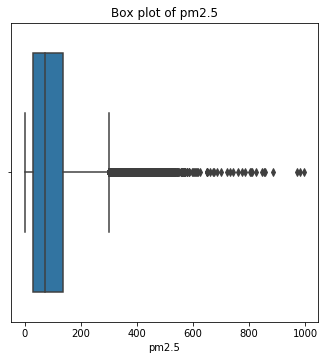

In [5]:
# Let us draw a box plot to visualize the central tendency and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['pm2.5'])
g.set_title('Box plot of pm2.5')

Text(0,0.5,'pm2.5 readings')

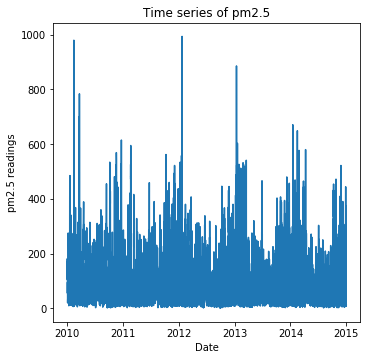

In [6]:
# Plot the time series
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(y=df['pm2.5'], x=df['datetime'])
g.set_title('Time series of pm2.5')
g.set_xlabel('Date')
g.set_ylabel('pm2.5 readings')

Text(0,0.5,'pm2.5 readings')

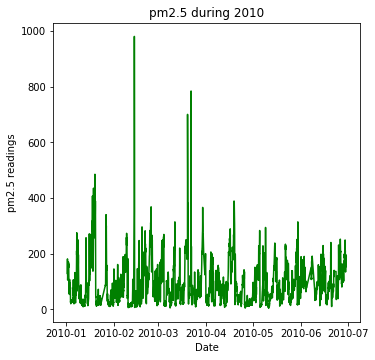

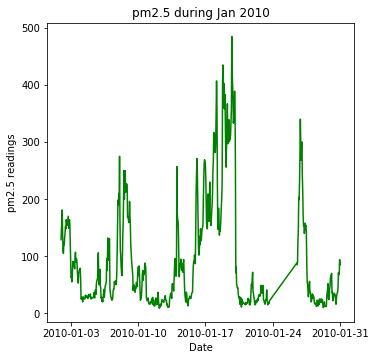

In [7]:
# Let's plot the series for six months to check if any pattern apparently exists.
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(
    y=df['pm2.5'].loc[df['datetime']<=datetime.datetime(year=2010,month=6,day=30)], 
    x=df['datetime'].loc[df['datetime']<=datetime.datetime(year=2010,month=6,day=30)],
    color='g'
)
g.set_title('pm2.5 during 2010')
g.set_xlabel('Date')
g.set_ylabel('pm2.5 readings')

# Let's zoom in on one month.
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(
    y=df['pm2.5'].loc[df['datetime']<=datetime.datetime(year=2010,month=1,day=31)],
    x=df['datetime'].loc[df['datetime']<=datetime.datetime(year=2010,month=1,day=31)],
    color='g'
)
g.set_title('pm2.5 during Jan 2010')
g.set_xlabel('Date')
g.set_ylabel('pm2.5 readings')

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. Many sources relax the boundary to even [-3, 3]. The pm2.5 variable is mixmax scaled to bound the tranformed variable within [0,1].

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_pm2.5'] = scaler.fit_transform(np.array(df['pm2.5']).reshape(-1, 1))

Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not neccesarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [9]:
# Let's start by splitting the dataset into train and validation. 
# The dataset's time period if from Jan 1st, 2010 to Dec 31st, 2014. 
# The first fours years - 2010 to 2013 is used as train and
# 2014 is kept for validation

split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (33096, 15)
Shape of test: (8661, 15)


In [10]:
# First five rows of train
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_pm2.5
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00,0.129779
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00,0.148893
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00,0.159960
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00,0.182093
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00,0.138833


In [11]:
# Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)
# First five rows of validation
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_pm2.5
0,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.024145
1,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.053320
2,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.065392
3,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.070423
4,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.079477


Text(0,0.5,'Scaled pm2.5 readings')

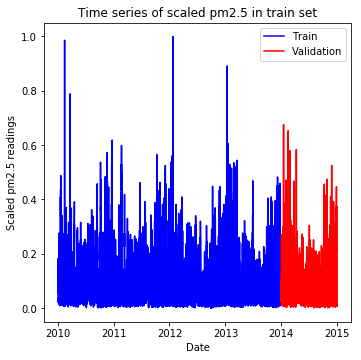

In [12]:
# The train and validation time series of scaled pm2.5 is also plotted.
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(
    y = df_train['scaled_pm2.5'],
    x = df_train['datetime'],
    color='b', label='Train'
)
g = sns.lineplot(
    y = df_val['scaled_pm2.5'],
    x = df_val['datetime'],
    color='r', label='Validation'
)
g.set_title('Time series of scaled pm2.5 in train set')
g.set_xlabel('Date')
g.set_ylabel('Scaled pm2.5 readings')

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressor and 1-D array of target is created from the original 1-D array of columm standardized_pm2.5 in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [13]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [14]:
X_train, y_train = makeXy(df_train['scaled_pm2.5'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (33089, 7) (33089,)


In [15]:
X_val, y_val = makeXy(df_val['scaled_pm2.5'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8654, 7) (8654,)


The input to RNN layers must be of shape (number of samples, number of timesteps, number of features per timestep). In this case we are modeling only pm2.5 hence number of features per timestep is one. Number of timesteps is seven and number of samples is same as the number of samples in X_train and X_val, which are reshaped to 3D arrays.

In [16]:
# X_train and X_val are reshaped to 3D arrays
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of arrays after reshaping: (33089, 7, 1) (8654, 7, 1)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [17]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [18]:
# Define input layer which has shape (1, 7) and of type float32
input_layer = Input(shape=(7,1), dtype='float32')

The GRU layers are defined for seven timesteps. In this example, two GRU layers are stacked. The first GRU returns the output from each all seven timesteps. This output is a sequence and is fed to the second GRU which returns output only from the last step. The first GRU has sixty four hidden neurons in each timestep. Hence the sequence returned by the first GRU has sixty four features.

In [19]:
gru_layer1 = GRU(64, input_shape=(7,1), return_sequences=True)(input_layer)
gru_layer2 = GRU(32, input_shape=(7,64), return_sequences=False)(gru_layer1)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
dropout_layer = Dropout(0.2)(gru_layer2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
# Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. The box plot of pm2.5 shows the presence of outliers. Hence, mean absolute error (MAE) is used as absolute deviations suffer less fluctuations compared to squared deviations.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [22]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 7, 64)             12672     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,017
Trainable params: 22,017
Non-trainable params: 0
_________________________________________________________________


The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.

In [23]:
save_weights_at = os.path.join(
    'keras_models', 'PRSA_data_PM2.5_GRU_weights.{epoch:02d}-{val_loss:.4f}.hdf5'
)
save_best = ModelCheckpoint(
    save_weights_at, monitor='val_loss', verbose=0,
    save_best_only=True, save_weights_only=False,
    mode='min', period=1
)
ts_model.fit(
    x=X_train, y=y_train, batch_size=16, epochs=20, 
    verbose=1, callbacks=[save_best],
    validation_data=(X_val, y_val), shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Train on 33089 samples, validate on 8654 samples
Epoch 1/20
33089/33089 [==============================] - 26s 778us/step - loss: 0.0169 - val_loss: 0.0122
Epoch 2/20
33089/33089 [==============================] - 26s 774us/step - loss: 0.0153 - val_loss: 0.0118
Epoch 3/20
33089/33089 [==============================] - 26s 773us/step - loss: 0.0151 - val_loss: 0.0119
Epoch 4/20
33089/33089 [==============================] - 24s 715us/step - loss: 0.0150 - val_loss: 0.0118
Epoch 5/20
33089/33089 [==============================] - 23s 703us/step - loss: 0.0149 - val_loss: 0.0127
Epoch 6/20
33089/33089 [==============================] - 23s 689us/step - loss: 0.0149 - val_loss: 0.0120
Epoch 7/20
33089/33089 [==============================] - 22s 676us/step - loss: 0.0149 - val_loss: 0.0121
Epoch 8/20
33089/33089 [==============================] - 22s 677us/step - loss: 0.0149 - val_loss: 0.0134
Epoch 9/20
33089/33089 [=======================

Prediction are made for the pm2.5 from the best saved model. The model's predictions, which are on the standardized  pm2.5, are inverse transformed to get predictions of original pm2.5.

In [24]:
best_model = load_model(os.path.join(
    'keras_models', 'PRSA_data_PM2.5_GRU_weights.13-0.0116.hdf5'
    )
)
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

In [25]:
from sklearn.metrics import mean_absolute_error

In [26]:
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

MAE for the validation set: 11.5545


Text(0,0.5,'Air Pressure')

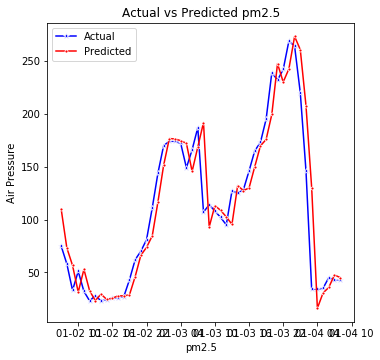

In [27]:
# Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
g = sns.lineplot(
    y=df_val.loc[7:56, 'pm2.5'], x=df_train.loc[7:56, 'datetime'],
    linestyle='-', marker='*', color='b'
)
g = sns.lineplot(
    y=pred_pm25[:50], x=df_train.loc[7:56, 'datetime'],
    linestyle='-', marker='.', color='r'
)
plt.legend(['Actual','Predicted'], loc=2)
g.set_title('Actual vs Predicted pm2.5')
g.set_xlabel('pm2.5')
g.set_ylabel('Air Pressure')